<a href="https://colab.research.google.com/github/TutiAmalia/Klasifikasi-Gambar-/blob/main/RecommendationSystem.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Proyek Kedua - Dicoding: Machine Learning Terapan**
# Sistem Rekomendasi: Rekomendasi Aplikasi untuk Pengguna di Microsoft Store



## Pendahuluan
Pada proyek ini, topik yang dibahas adalah mengenai sistem rekomendasi untuk pengguna di Microsoft Store. 

Adapun informasi dataset yang digunakan:

Jenis  | Keterangan
-------------------|------------------
Sumber     | [Kaggle Dataset : Microsoft Store](https://www.kaggle.com/vishnuvarthanrao/windows-store)
Lisensi     | CC0: Public Domain
Kategori     | bisnis, seni dan hiburan, software
Rating Penggunaan     | 10.0 (Gold)
Jenis dan ukuran berkas     | CSV (300 kB)


Informasi variabel yang digunakan

Variable  | Definition 
-------------------|------------------
Name      | Nama aplikasi
Rating      | Peringkat untuk aplikasi
No of People Rated | Jumlah pengguna yang menilai aplikasi
Category | Kategori pada aplikasi
Date | Tanggal saat diposting
Price | Harga aplikasi

In [1]:
# Library
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import pandas as pd
import missingno as msno 
%matplotlib inline
import seaborn as sns

from sklearn.preprocessing import StandardScaler

from sklearn.metrics.pairwise import cosine_similarity
from sklearn.neighbors import NearestNeighbors

from google.colab import files

from sklearn.metrics import davies_bouldin_score

# Mempersiapkan Dataset

In [2]:
# Mengambil dataset dari Kaggle
!pip install -q kaggle
uploaded = files.upload()

Saving kaggle.json to kaggle.json


In [3]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [4]:
# Mengunduh dataset menggunakan Kaggle CLI
!kaggle datasets download -d vishnuvarthanrao/windows-store

windows-store.zip: Skipping, found more recently modified local copy (use --force to force download)


In [5]:
# Mengekstrak berkas zip
!unzip /content/windows-store.zip

Archive:  /content/windows-store.zip
  inflating: msft.csv                


# Data Understanding

In [6]:
# Memuat data pada dataframe
df = pd.read_csv('/content/msft.csv')
df

,Name,Rating,No of people Rated,Category,Date,Price
0,Dynamic Reader,3.5,268,Books,07-01-2014,Free
1,"Chemistry, Organic Chemistry and Biochemistry-...",3.0,627,Books,08-01-2014,Free
2,BookViewer,3.5,593,Books,29-02-2016,Free
3,Brick Instructions,3.5,684,Books,30-01-2018,Free
4,Introduction to Python Programming by GoLearni...,2.0,634,Books,30-01-2018,Free
...,...,...,...,...,...,...
5317,JS King,1.0,720,Developer Tools,19-07-2018,₹ 269.00
5318,MQTTSniffer,2.5,500,Developer Tools,10-04-2017,₹ 64.00
5319,"Dev Utils - JSON, CSV and XML",4.0,862,Developer Tools,18-11-2019,₹ 269.00
5320,Simply Text,4.0,386,Developer Tools,23-01-2014,₹ 219.00


In [7]:
# memuat informasi setiap kolom dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5322 entries, 0 to 5321
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Name                5321 non-null   object 
 1   Rating              5321 non-null   float64
 2   No of people Rated  5322 non-null   int64  
 3   Category            5321 non-null   object 
 4   Date                5321 non-null   object 
 5   Price               5321 non-null   object 
dtypes: float64(1), int64(1), object(4)
memory usage: 249.6+ KB


In [8]:
# cek apakah terdapat missing data
df.isnull().sum()

Name                  1
Rating                1
No of people Rated    0
Category              1
Date                  1
Price                 1
dtype: int64

In [9]:
# Persentase nilai yg null
df.isnull().sum()/len(df)*100

Name                  0.01879
Rating                0.01879
No of people Rated    0.00000
Category              0.01879
Date                  0.01879
Price                 0.01879
dtype: float64

In [10]:
# Memuat deskripsi setiap kolom dataframe
df.describe()

,Rating,No of people Rated
count,5321.000000,5322.000000
mean,3.792708,551.873168
std,0.991681,259.820088
min,1.000000,100.000000
25%,3.500000,327.000000
50%,4.000000,548.000000
75%,4.500000,779.000000
max,5.000000,1000.000000


# Data Preparation

## Pembersihan Data setiap kolom

In [11]:
# Menghapus data NaN
df.dropna(inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5321 entries, 0 to 5320
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Name                5321 non-null   object 
 1   Rating              5321 non-null   float64
 2   No of people Rated  5321 non-null   int64  
 3   Category            5321 non-null   object 
 4   Date                5321 non-null   object 
 5   Price               5321 non-null   object 
dtypes: float64(1), int64(1), object(4)
memory usage: 291.0+ KB


- Kolom Rating

In [12]:
# Melihat data unik pada kolom rating
df['Rating'].unique()

array([3.5, 3. , 2. , 4.5, 4. , 1. , 2.5, 5. , 1.5])

In [13]:
# Mencari apakah ada data rating yang nilainya lebih dari 5
if(len(df[df['Rating']>5])):
  print('Terdapat nilai rating diatas 5')
else:
  print('Tidak ada nilai rating diatas 5')

Tidak ada nilai rating diatas 5


In [14]:
# Melihat data unik pada kolom No of people Rated
# df['No of people Rated'].unique()

- Kolom Category

In [15]:
# Melihat data unik pada kolom Category
df['Category'].unique()

array(['Books', 'Business', 'Developer Tools', 'Social',
       'Food and Dining', 'Government and Politics', 'Health and Fitness',
       'Kids and Family', 'Lifestyle', 'Multimedia Design', 'Music',
       'Navigation and Maps', 'News and Weather'], dtype=object)

In [16]:
# Preprocessing the category column
df['Category']=df['Category'].str.replace(' ','_')

- Kolom Date

In [17]:
# Mengubah tipe data kolom date
df['Date']= pd.to_datetime(df['Date'], format='%d-%m-%Y')
df.head()

,Name,Rating,No of people Rated,Category,Date,Price
0,Dynamic Reader,3.5,268,Books,2014-01-07,Free
1,"Chemistry, Organic Chemistry and Biochemistry-...",3.0,627,Books,2014-01-08,Free
2,BookViewer,3.5,593,Books,2016-02-29,Free
3,Brick Instructions,3.5,684,Books,2018-01-30,Free
4,Introduction to Python Programming by GoLearni...,2.0,634,Books,2018-01-30,Free


- Kolom Price

In [18]:
# Melihat data unik pada kolom price
df['Price'].unique()

array(['Free', '₹ 144.00', '₹ 54.00', '₹ 99.00', '₹ 219.00', '₹ 269.00',
       '₹ 134.00', '₹ 164.00', '₹ 109.00', '₹ 1,624.00', '₹ 1,099.00',
       '₹ 1,349.00', '₹ 59.00', '₹ 154.00', '₹ 119.00', '₹ 94.00',
       '₹ 69.00', '₹ 139.00', '₹ 189.00', '₹ 549.00', '₹ 79.00',
       '₹ 2,599.00', '₹ 299.00', '₹ 574.00', '₹ 329.40', '₹ 1,521.80',
       '₹ 324.00', '₹ 824.00', '₹ 5,449.00', '₹ 89.50', '₹ 114.00',
       '₹ 194.00', '₹ 319.00', '₹ 624.00', '₹ 2,149.00', '₹ 1,149.00',
       '₹ 434.00', '₹ 279.00', '₹ 209.00', '₹ 699.00', '₹ 1,899.00',
       '₹ 489.00', '₹ 54.50', '₹ 64.00'], dtype=object)

In [19]:
# Preprocessing the price column
df['Price']=df['Price'].str.replace('Free','0')
df['Price']=df['Price'].str.replace('₹ ','')
df['Price']=df['Price'].str.replace(',','')
df['Price']=df['Price'].astype('float')

In [20]:
# Mengecek kembali nilai pada kolom Price
df['Price'].unique()

array([   0. ,  144. ,   54. ,   99. ,  219. ,  269. ,  134. ,  164. ,
        109. , 1624. , 1099. , 1349. ,   59. ,  154. ,  119. ,   94. ,
         69. ,  139. ,  189. ,  549. ,   79. , 2599. ,  299. ,  574. ,
        329.4, 1521.8,  324. ,  824. , 5449. ,   89.5,  114. ,  194. ,
        319. ,  624. , 2149. , 1149. ,  434. ,  279. ,  209. ,  699. ,
       1899. ,  489. ,   54.5,   64. ])

# Visualisasi Data

## - Jumlah aplikasi berdasarkan Rating

Text(0.5, 1.02, 'Jumlah Aplikasi berdasarkan Peringkat')

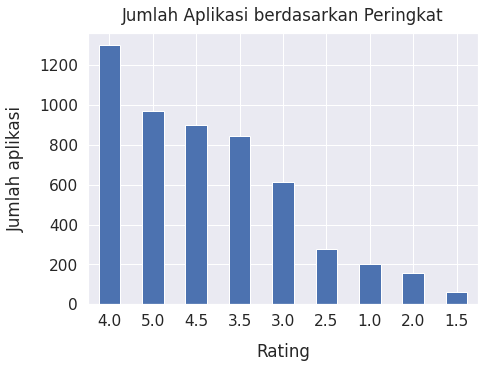

In [21]:
sns.set(font_scale=1.4)

df['Rating'].value_counts().plot(kind='bar', figsize=(7, 5), rot=0)
plt.xlabel('Rating', labelpad=14)
plt.ylabel('Jumlah aplikasi', labelpad=14)
plt.title('Jumlah Aplikasi berdasarkan Peringkat', y=1.02)

## - Jumlah aplikasi berdasarkan kategori

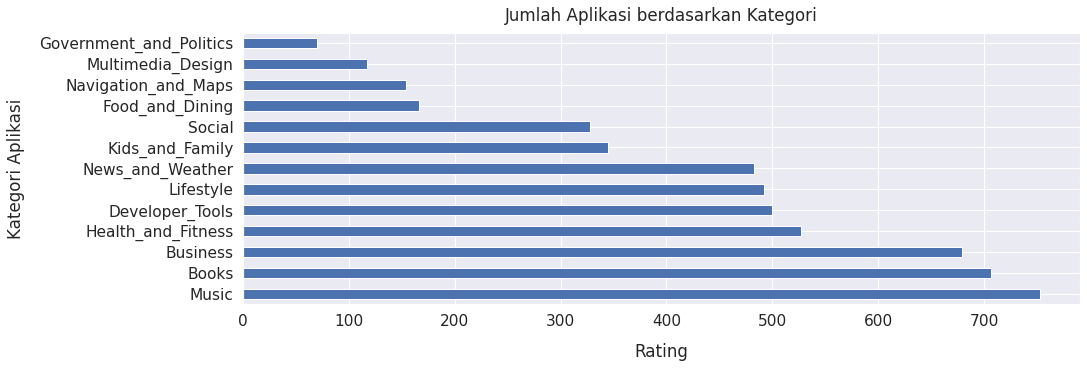

In [22]:
sns.set(font_scale=1.4)

df['Category'].value_counts().plot(kind='barh', figsize=(15, 5), rot=0)
plt.xlabel('Rating', labelpad=14)
plt.ylabel('Kategori Aplikasi', labelpad=14)
plt.title('Jumlah Aplikasi berdasarkan Kategori', y=1.02);

## - Rata-rata peringkat berdasarkan kategori dan jumlah orang yang menilai

In [23]:
total = pd.DataFrame(df.groupby(['Category'])['No of people Rated'].sum().reset_index())
avg_rat = pd.DataFrame(df.groupby(['Category'])['Rating'].mean().reset_index())

final = total 
final['Average Rating'] = avg_rat['Rating']

fig = px.scatter(final, x='Average Rating', y='Category', size='No of people Rated', color='Category')
fig.update_layout(title='Average Rating - Category wise')
fig.show()

## - Rasio Harga pada aplikasi

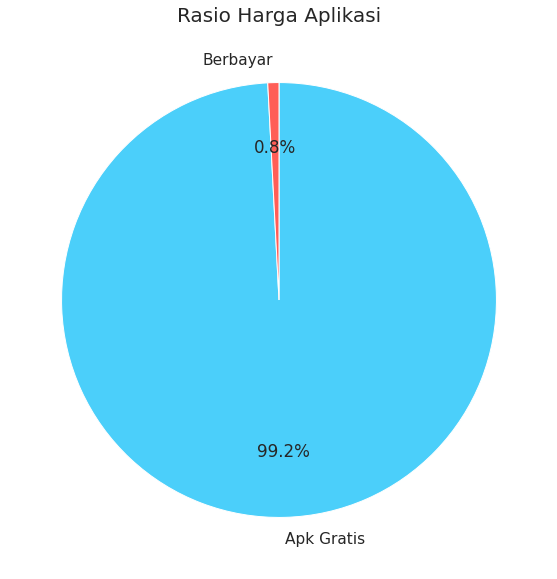

In [24]:
tmp1 = df[['Price']].reset_index()
tmp1 = tmp1.groupby(['Price']).count().reset_index()
tmp1 = tmp1.rename(columns={'index': 'count'})

tmp2 = tmp1[tmp1['Price']!=0].reset_index()
tmp2 = tmp2.groupby(['Price']).count().reset_index()
sum_not_free = tmp2['count'].sum()

tmp1 = tmp1[:1]
Pcount = tmp1.append({'Price': 'Berbayar', 'count':sum_not_free }, ignore_index=True)
Pcount.loc[Pcount['Price']==0, 'Price'] = "Apk Gratis"

label = Pcount['Price']
color = ("#4bcffa","#ff5e57")

plt.figure(figsize=(15,10))
plt.title("Rasio Harga Aplikasi",fontsize=20)

plt.pie(Pcount['count'],labels=label,colors=color,counterclock=False, startangle=90,autopct='%1.1f%%', pctdistance=0.7)
plt.show()

## - Jumlah orang yang menilai setiap tahun - Rata-rata

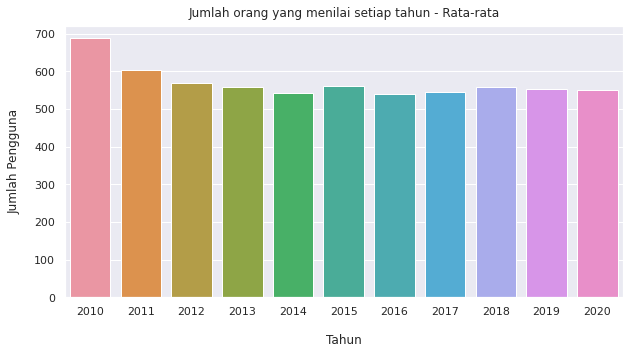

In [25]:
# Menyortir nilai berdasarkan Date
dte = df.sort_values(by='Date', ascending=True)

# Menetapkan indeks sebagai tanggal
dte.index = dte.Date

# Resampling data berdasarkan tahun
yr=dte.resample('Y').mean()

sns.set(rc={'figure.figsize':(10,5)})
sns.barplot(x=yr.index.year, y='No of people Rated', data=yr)
plt.xlabel('Tahun', labelpad=17)
plt.ylabel('Jumlah Pengguna', labelpad=14)

plt.title('Jumlah orang yang menilai setiap tahun - Rata-rata', y=1.01);


##- Menghapus kolom yang tidak digunakan

In [26]:
# Menghapus kolom Date
df.drop('Date',inplace=True,axis=1)
df.head()

,Name,Rating,No of people Rated,Category,Price
0,Dynamic Reader,3.5,268,Books,0.0
1,"Chemistry, Organic Chemistry and Biochemistry-...",3.0,627,Books,0.0
2,BookViewer,3.5,593,Books,0.0
3,Brick Instructions,3.5,684,Books,0.0
4,Introduction to Python Programming by GoLearni...,2.0,634,Books,0.0


In [27]:
df1 = df.copy()
df1.head()

,Name,Rating,No of people Rated,Category,Price
0,Dynamic Reader,3.5,268,Books,0.0
1,"Chemistry, Organic Chemistry and Biochemistry-...",3.0,627,Books,0.0
2,BookViewer,3.5,593,Books,0.0
3,Brick Instructions,3.5,684,Books,0.0
4,Introduction to Python Programming by GoLearni...,2.0,634,Books,0.0


# Pembuatan Sistem Rekomendasi Content Based Filtering

# K-Nearest Neighbor

In [28]:
# Menyimpan nama-nama aplikasi pada dataframe baru
df_name = pd.DataFrame({'Name':df['Name']})
df_name.head()

,Name
0,Dynamic Reader
1,"Chemistry, Organic Chemistry and Biochemistry-..."
2,BookViewer
3,Brick Instructions
4,Introduction to Python Programming by GoLearni...


In [29]:
# Menggunakan kolom Name sebagai index
df.set_index('Name',inplace=True)
df.head()

,Rating,No of people Rated,Category,Price
Name,,,,
Dynamic Reader,3.5,268,Books,0.0
"Chemistry, Organic Chemistry and Biochemistry-simpleNeasyApp by WAGmob",3.0,627,Books,0.0
BookViewer,3.5,593,Books,0.0
Brick Instructions,3.5,684,Books,0.0
Introduction to Python Programming by GoLearningBus,2.0,634,Books,0.0


In [30]:
# Memilih kolom dengan tipe data object
col_obj = df.dtypes[df.dtypes == 'object'].keys()
col_obj

Index(['Category'], dtype='object')

In [31]:
# Mengkonversi data kategori ke one-hot encoding
one_hot = pd.get_dummies(df[col_obj])
one_hot.head(3)

,Category_Books,Category_Business,Category_Developer_Tools,Category_Food_and_Dining,Category_Government_and_Politics,Category_Health_and_Fitness,Category_Kids_and_Family,Category_Lifestyle,Category_Multimedia_Design,Category_Music,Category_Navigation_and_Maps,Category_News_and_Weather,Category_Social
Name,,,,,,,,,,,,,
Dynamic Reader,1,0,0,0,0,0,0,0,0,0,0,0,0
"Chemistry, Organic Chemistry and Biochemistry-simpleNeasyApp by WAGmob",1,0,0,0,0,0,0,0,0,0,0,0,0
BookViewer,1,0,0,0,0,0,0,0,0,0,0,0,0


In [32]:
# Menghapus kolom dengan tipe data object yakni kolom Category
df.drop(col_obj,axis=1,inplace=True)
df.head()

,Rating,No of people Rated,Price
Name,,,
Dynamic Reader,3.5,268,0.0
"Chemistry, Organic Chemistry and Biochemistry-simpleNeasyApp by WAGmob",3.0,627,0.0
BookViewer,3.5,593,0.0
Brick Instructions,3.5,684,0.0
Introduction to Python Programming by GoLearningBus,2.0,634,0.0


In [33]:
# Menyatukan data dari one hot encoding dengan seluruh data
df = pd.concat([df,one_hot],axis=1)
df.head()

,Rating,No of people Rated,Price,Category_Books,Category_Business,Category_Developer_Tools,Category_Food_and_Dining,Category_Government_and_Politics,Category_Health_and_Fitness,Category_Kids_and_Family,Category_Lifestyle,Category_Multimedia_Design,Category_Music,Category_Navigation_and_Maps,Category_News_and_Weather,Category_Social
Name,,,,,,,,,,,,,,,,
Dynamic Reader,3.5,268,0.0,1,0,0,0,0,0,0,0,0,0,0,0,0
"Chemistry, Organic Chemistry and Biochemistry-simpleNeasyApp by WAGmob",3.0,627,0.0,1,0,0,0,0,0,0,0,0,0,0,0,0
BookViewer,3.5,593,0.0,1,0,0,0,0,0,0,0,0,0,0,0,0
Brick Instructions,3.5,684,0.0,1,0,0,0,0,0,0,0,0,0,0,0,0
Introduction to Python Programming by GoLearningBus,2.0,634,0.0,1,0,0,0,0,0,0,0,0,0,0,0,0


In [34]:
# Memilih semua kolom dengan tipe data integer
col_int = df.dtypes[df.dtypes == 'int64'].keys()
col_int

Index(['No of people Rated'], dtype='object')

In [35]:
# Memilih semua kolom dengan tipe data float
col_float = df.dtypes[df.dtypes == 'float64'].keys()
col_float

Index(['Rating', 'Price'], dtype='object')

In [36]:
# Menyatukan semua kolom dengan tipe data numerik
col_num = list(col_int) + list(col_float)
col_num

['No of people Rated', 'Rating', 'Price']

## Standarisasi nilai data pada fitur numerik dengan StandarScaler

In [37]:
# Inisiasi StandardScaler()
scaler = StandardScaler()

In [38]:
# Melakukan standarisasi data
scaled = scaler.fit_transform(df[col_num])

In [39]:
# Mengganti data numerik dengan data yang sudah di standarisasi
i=0
for column in col_num:
    df[column] = scaled[:,i]
    i += 1

In [40]:
# Melihat hasil standarisasi data
df.head()

,Rating,No of people Rated,Price,Category_Books,Category_Business,Category_Developer_Tools,Category_Food_and_Dining,Category_Government_and_Politics,Category_Health_and_Fitness,Category_Kids_and_Family,Category_Lifestyle,Category_Multimedia_Design,Category_Music,Category_Navigation_and_Maps,Category_News_and_Weather,Category_Social
Name,,,,,,,,,,,,,,,,
Dynamic Reader,-0.295191,-1.092528,-0.093968,1,0,0,0,0,0,0,0,0,0,0,0,0
"Chemistry, Organic Chemistry and Biochemistry-simpleNeasyApp by WAGmob",-0.799433,0.289499,-0.093968,1,0,0,0,0,0,0,0,0,0,0,0,0
BookViewer,-0.295191,0.158611,-0.093968,1,0,0,0,0,0,0,0,0,0,0,0,0
Brick Instructions,-0.295191,0.508930,-0.093968,1,0,0,0,0,0,0,0,0,0,0,0,0
Introduction to Python Programming by GoLearningBus,-1.807916,0.316447,-0.093968,1,0,0,0,0,0,0,0,0,0,0,0,0


In [41]:
# Memuat deskripsi setiap kolom dataframe
df.describe()

,Rating,No of people Rated,Price,Category_Books,Category_Business,Category_Developer_Tools,Category_Food_and_Dining,Category_Government_and_Politics,Category_Health_and_Fitness,Category_Kids_and_Family,Category_Lifestyle,Category_Multimedia_Design,Category_Music,Category_Navigation_and_Maps,Category_News_and_Weather,Category_Social
count,5.321000e+03,5.321000e+03,5.321000e+03,5321.000000,5321.000000,5321.000000,5321.000000,5321.000000,5321.000000,5321.000000,5321.000000,5321.000000,5321.000000,5321.000000,5321.000000,5321.000000
mean,-9.718259e-16,2.016804e-16,-9.824045e-16,0.132870,0.127608,0.093967,0.031197,0.013155,0.099042,0.064837,0.092464,0.021988,0.141515,0.028942,0.090772,0.061643
std,1.000094e+00,1.000094e+00,1.000094e+00,0.339466,0.333684,0.291811,0.173867,0.113951,0.298746,0.246262,0.289707,0.146659,0.348585,0.167659,0.287312,0.240528
min,-2.816399e+00,-1.739271e+00,-9.396770e-02,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,-2.951913e-01,-8.653982e-01,-9.396770e-02,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,2.090504e-01,-1.462378e-02,-9.396770e-02,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,7.132920e-01,8.746473e-01,-9.396770e-02,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.217534e+00,1.725422e+00,4.640242e+01,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [44]:
# Inisialisasi model
model=NearestNeighbors(metric='euclidean', algorithm='brute')

# Melakukan fitting model terhadap data
model.fit(df)

NearestNeighbors(algorithm='brute', leaf_size=30, metric='euclidean',
                 metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                 radius=1.0)



---



---



# Cosine Similarity


In [47]:
# Mengonversi data series ‘Name’ menjadi dalam bentuk list
name = df1['Name'].tolist()

In [48]:
# Menyimpan nama-nama aplikasi dan kategorinya pada dataframe baru
df_cat = pd.DataFrame({'Name':df1['Name'], 'Category':df1['Category']})
df_cat.head()

,Name,Category
0,Dynamic Reader,Books
1,"Chemistry, Organic Chemistry and Biochemistry-...",Books
2,BookViewer,Books
3,Brick Instructions,Books
4,Introduction to Python Programming by GoLearni...,Books


## TF-IDF Vectorizer

In [49]:
from sklearn.feature_extraction.text import TfidfVectorizer
 
# Inisialisasi TfidfVectorizer
tf = TfidfVectorizer()
 
# Melakukan perhitungan idf pada data category
tf.fit(df_cat['Category']) 
 
# Mapping array dari fitur index integer ke fitur nama
tf.get_feature_names() 

['books',
 'business',
 'developer_tools',
 'food_and_dining',
 'government_and_politics',
 'health_and_fitness',
 'kids_and_family',
 'lifestyle',
 'multimedia_design',
 'music',
 'navigation_and_maps',
 'news_and_weather',
 'social']

In [50]:
# Melakukan fit lalu ditransformasikan ke bentuk matrix
tfidf_matrix = tf.fit_transform(df1['Category']) 
 
# Melihat ukuran matrix tfidf
tfidf_matrix.shape 

(5321, 13)

In [51]:
# Mengubah vektor tf-idf dalam bentuk matriks dengan fungsi todense()
tfidf_matrix.todense()

matrix([[1., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 1., ..., 0., 0., 0.],
        [0., 0., 1., ..., 0., 0., 0.],
        [0., 0., 1., ..., 0., 0., 0.]])

In [61]:
# Membuat dataframe untuk melihat tf-idf matrix
# Kolom diisi dengan jenis masakan
# Baris diisi dengan nama resto

pd.DataFrame(
    tfidf_matrix.todense(), 
    columns=tf.get_feature_names(),
    index= df_cat['Name']
).sample(13, axis=1).sample(10, axis=0)

,social,government_and_politics,business,music,health_and_fitness,navigation_and_maps,developer_tools,kids_and_family,books,news_and_weather,multimedia_design,food_and_dining,lifestyle
Name,,,,,,,,,,,,,
Orange Countdown,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Moon Phases PRO,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
IP Controller,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
SQL Server Description Editor,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
MadMonkey,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
90 Days Challenge,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
RSCameraViewer,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
"Sygic: GPS Navigation, Maps & POI, Route Directions",0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Adobe Acrobat Reader DC PC Guide,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [62]:
from sklearn.metrics.pairwise import cosine_similarity
 
# Menghitung cosine similarity pada matrix tf-idf
cosine_sim = cosine_similarity(tfidf_matrix) 
cosine_sim

array([[1., 1., 1., ..., 0., 0., 0.],
       [1., 1., 1., ..., 0., 0., 0.],
       [1., 1., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 1., 1.],
       [0., 0., 0., ..., 1., 1., 1.],
       [0., 0., 0., ..., 1., 1., 1.]])

In [63]:
# Membuat dataframe dari variabel cosine_sim dengan baris dan kolom berupa nama resto
cosine_sim_df = pd.DataFrame(cosine_sim, index=df1['Name'], columns=df1['Name'])
print('Shape:', cosine_sim_df.shape)
 
# Melihat similarity matrix pada setiap resto
cosine_sim_df.sample(5, axis=1).sample(10, axis=0)

Shape: (5321, 5321)


Name,UBIK.UWP,Chemical Engineering by WAGmob,Cheerful Princess Makeup Game,Regina Leader-Post ePaper,Smart Notepad (+ Hidden Vault to store Private Pictures & Videos)
Name,,,,,
Turtles Paint,0.0,0.0,1.0,0.0,0.0
ArtisGL 3D Publisher,0.0,0.0,0.0,0.0,0.0
Agenda for Google Calendar.,1.0,0.0,0.0,0.0,0.0
Sampler,0.0,0.0,0.0,0.0,0.0
Simple Cube Timer,0.0,0.0,0.0,0.0,0.0
Media Player (+ Hidden Photos Videos Gallery Locker),0.0,0.0,0.0,0.0,0.0
Nocturne,0.0,0.0,0.0,1.0,1.0
Spanish<>English Dictionary,0.0,1.0,0.0,0.0,0.0
News Reader for BBC TV News,0.0,0.0,0.0,1.0,1.0




---



---



# Mendapatkan Rekomendasi

## K-Nearest Neighbor

In [66]:
# Fungsi untuk mendapatkan aplikasi yang direkomendasikan berdasarkan nearest
# neighbors pada kategori aplikasi
def getRecommendationsKnn(title, k=5):
  # Mencari aplikasi terdekat berdasarkan aplikasi yang disukai pengguna
  score, neighbors = model.kneighbors([df.loc[title]], n_neighbors=k+1)

  # mengambil nama yang akan direkomendasikan
  neighbors = [i[-k:] for i in neighbors][0]
  # mengambil score yang akan direkomendasikan
  score = [(100-i[-k:])*0.01 for i in score][0]
  print('Model yang digunakan K-NearestNeighbors')
  print('Pengguna menyukai aplikasi {} \nMaka {} aplikasi yang akan direkomendasikan yakni:'.format(title, k))
  return pd.DataFrame(data = {'Name': titles.iloc[neighbors], 'Score Similarity':score})

getRecommendationsKnn('WhatsApp Desktop')


Model yang digunakan K-NearestNeighbors
Pengguna menyukai aplikasi WhatsApp Desktop 
Maka 5 aplikasi yang akan direkomendasikan yakni:


,Name,Score Similarity
1742,TextNow - Unlimited Texts + Calls,0.999269
2021,PocketPC.ch für Windows 10,0.998999
1827,Easyscope Beta,0.998807
2014,Eden,0.998460
1763,KakaoTalk,0.998268


In [67]:
# Membangun array 1 dimensi dengan nama aplikasi
titles = df_cat['Name']
indices = pd.Series(df_cat.index, index=df_cat['Name'])

# Fungsi untuk mendapatkan aplikasi yang direkomendasikan berdasarkan cosine
# similarity pada kategori aplikasi
def getRecomendationCosine(title, k=5):
    idx = indices[title]

    # membuat list dari setiap nama aplikasi
    sim_scores = list(enumerate(cosine_sim[idx]))

    # menyortir hasil dari list sesuai dengan jumlah yang diinginkan
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:k+1]

    # mengambil nama yang akan direkomendasikan
    apk_indices = [i[0] for i in sim_scores]
    # mengambil nilai similarity dari nama yang direkomendasikan
    scores = [i[1] for i in sim_scores]

    print('Model yang digunakan Cosine Similarity')
    print('Pengguna menyukai aplikasi {} \nMaka {} aplikasi yang akan direkomendasikan yakni:'.format(title, k))
    return pd.DataFrame(data = {"Nama Aplikasi" : titles.iloc[apk_indices], "Score Similarity" : scores}) 

getRecomendationCosine('WhatsApp Desktop')


Model yang digunakan Cosine Similarity
Pengguna menyukai aplikasi WhatsApp Desktop 
Maka 5 aplikasi yang akan direkomendasikan yakni:


,Nama Aplikasi,Score Similarity
1729,Instagram,1.0
1730,Telegram Desktop,1.0
1731,Pinterest,1.0
1732,Messenger,1.0
1733,imo desktop free video calls and chat,1.0


# Evaluasi Model

In [46]:
# metric skor Davies Bouldin
davies_bouldin_score(df, df_name)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



0.7114420695159827